# ACME


# Detailed Plan

Bold letters are the steps covered in ths notebook

1.	Data Ingestion & Splitting. Load Dataset, it is already into train (90%), validation (5%), and test (5%). Then, verify data quality, label integrity and clean.

2.	Descriptive Analytics & KPIs. Run basic stats and define evaluation KPIs like ROUGE-Lsum, summary length and compression ratio to guide model selection and track progress.

3.	Model Selection (Baseline Shootout). Benchmark BERT2BERT vs GPT-2 under the same preprocessing and decoding setup; select the stronger baseline using ROUGE-Lsum plus quick qualitative checks.

4.	Phase A — Training Optimization. Tune core training hyperparameters (learning rate, weight decay, label smoothing, warmup) with a data subset to establish the best fine-tuned checkpoint.

5.	Phase B — Decoding Optimization (Inference Only). Run a full-validation grid over num_beams, length_penalty, no_repeat_ngram_size, max_new_tokens to improve output quality without retraining.

6.	**Targeted Case Reviews. Assess faithfulness and tone on three representative examples (idx 654, 114, 25) to validate real-world usefulness beyond metrics.**

7.	**Final Diagnostics & Readiness Check. Summarize length distributions, compression ratios, and generated vs. reference comparisons; document risks and guardrails to ensure summaries are concise, accurate, and deployment ready.**


**Notebook 3 (sampling)**

In this section, I will focus on applying the best-performing model from Phase A. The model checkpoint, previously identified through systematic hyperparameter exploration, is retrieved directly from my Google Drive. Rather than repeating the full evaluation pipeline, I restrict the experiment to three specific validation samples (indices 654, 114, and 25).

The purpose is to provide a qualitative inspection of the model’s behavior on real dialogues. For each sample, I present the original conversation, the human-written reference summary, and the model-generated summary. This comparison offers a transparent view of how well the model captures key information in unseen text.

It is important to note that I am not re-running ROUGE evaluation here, as quantitative scoring was already completed in Project_Variant_2. Instead, this exercise serves as a complementary check—highlighting strengths and potential shortcomings of the best Phase A model when applied to individual examples.

# ROUGE Metric

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a family of metrics for summarization that compares a model’s output against human-written reference (Exactly what we have fo ACME) summaries by measuring n-gram overlap (e.g., unigrams, bigrams, or longer sequences). In simple terms, it checks how many of the same words and phrases appear in both the generated and reference summaries.

ROUGE is the most widely used evaluation metric for text summarization research, making results comparable to prior work. Since SAMSum provides human-written reference summaries, ROUGE directly measures how well the model reproduces the essential content. ROUGE can be computed quickly and consistently across thousands of validation examples, which is crucial in Phase A (model sweeps) and Phase B (decoding sweeps).

Even though ROUGE does not capture humor or pragmatic tone, it provides a stable and quantitative way to rank candidate models or decoding strategies, which was exactly the goal in both Phase A and Phase B.

In short, ROUGE is simple, fast, and well-aligned with the SAMSum benchmark, making it the right choice for model selection across both phases.

## Why ROUGE-Lsum?

Within the ROUGE family, we used ROUGE-Lsum as the primary selection metric.

ROUGE-L measures the Longest Common Subsequence (LCS) between the generated summary and the reference. Unlike fixed n-grams, it rewards sequences of words that appear in the same order, even if they are not strictly consecutive. This makes it better at capturing sentence-level fluency.

The “-sum” variant adapts ROUGE-L specifically for summarization tasks: it applies the LCS comparison at the summary level (multiple sentences) rather than treating the text as one long string. This avoids unfair penalties when sentence boundaries differ between model and reference.

Why it fits Phase A and Phase B? In SAMSum, summaries are short (often one or two sentences) and rely on capturing the main idea in order. ROUGE-Lsum is sensitive to this structure, making it more reliable than ROUGE-1 (just word overlap) or ROUGE-2 (short phrase overlap) when ranking models.

In short, ROUGE-Lsum balances precision and recall while respecting sentence boundaries, making it a strong metric for evaluating abstractive dialogue summaries in both training (Phase A) and decoding optimization (Phase B).

# Phase A - Results

This code inspects the current Colab working directory to identify any saved Phase A experiment folders and verify whether valid encoder–decoder model checkpoints are present. It first lists the top-level files, then searches for Phase A run directories, and finally scans recursively for config.json files containing an encoder-decoder model type. This ensures that the correct checkpoints are available before reloading the best model for inference.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE = Path('/content/drive/MyDrive/Colab Notebooks/EIA')

Mounted at /content/drive


In [9]:
# What’s in the current working dir?

import os, glob, json, pathlib
from pathlib import Path

print("CWD:", Path(".").resolve())
print("Top-level dirs/files:", os.listdir("."))

# B. Find any Phase-A-like folders in /content (current runtime)
cands = sorted(glob.glob("/content/b2b-hpo-*"))
print("\nCandidates under /content:")
for c in cands:
    print(" -", c)

# C. More robust: search for *encoder-decoder* configs anywhere under /content
hits = []
for cfg in glob.glob("/content/**/config.json", recursive=True):
    try:
        with open(cfg, "r") as f:
            j = json.load(f)
        if "model_type" in j and j["model_type"] == "encoder-decoder":
            hits.append(cfg)
    except Exception:
        pass

print("\nEncoder-decoder configs found under /content:")
for h in hits:
    print(" -", h, " (parent:", str(Path(h).parent), ")")

CWD: /content
Top-level dirs/files: ['.config', 'drive', 'sample_data']

Candidates under /content:

Encoder-decoder configs found under /content:
 - /content/drive/MyDrive/bert2bert_samsum_checkpoint/config.json  (parent: /content/drive/MyDrive/bert2bert_samsum_checkpoint )


The following code reloads the best Phase A checkpoint from Google Drive for inference. It first inspects the directory to check for available sub-checkpoints, then selects the most recent one. The model and tokenizer are loaded locally (without relying on the Hugging Face Hub), and the necessary configuration values—such as decoder start, end-of-sequence, and padding tokens—are set to ensure the model can properly generate summaries.

In [4]:
from pathlib import Path
from transformers import EncoderDecoderModel, AutoTokenizer

best_dir = Path("/content/drive/MyDrive/bert2bert_samsum_checkpoint")

# 1) Inspect what's inside
print("Contents:", [p.name for p in best_dir.iterdir()])

# 2) If this is a *root run dir* with checkpoint-* subfolders, hop to the newest checkpoint
ckpts = sorted(best_dir.glob("checkpoint-*"), key=lambda p: int(p.name.split("-")[-1]))
load_dir = ckpts[-1] if ckpts else best_dir
print("Loading from:", load_dir)

# 3) Load model locally (no Hub). This folder must contain: config.json + pytorch_model.bin (or safetensors)
best_model = EncoderDecoderModel.from_pretrained(str(load_dir), local_files_only=True)

# 4) Load tokenizer (prefer the same folder; otherwise fall back to your base tokenizer)
try:
    tokenizer = AutoTokenizer.from_pretrained(str(best_dir), local_files_only=True)
except Exception:
    tokenizer = AutoTokenizer.from_pretrained(enc_dec_name)  # fallback to your original tokenizer
print("Model & tokenizer loaded!")

# 5) Set generation-time IDs and enable cache for inference
best_model.config.decoder_start_token_id = tokenizer.cls_token_id
best_model.config.eos_token_id           = tokenizer.sep_token_id
best_model.config.pad_token_id           = tokenizer.pad_token_id
best_model.config.use_cache              = True

Contents: ['ds_train', 'ds_val', 'config.json', 'generation_config.json', 'model.safetensors', 'trainer_state.json', 'tokenizer_config.json', 'tokenizer.json', 'vocab.txt', 'special_tokens_map.json', 'training_args.bin']
Loading from: /content/drive/MyDrive/bert2bert_samsum_checkpoint
Model & tokenizer loaded!


The following code loads the SAMSum dataset and prepares the train, validation, and test splits, filtering out any missing values. It defines a helper function to generate summaries with the already-loaded best model and tokenizer, and a wrapper for clean text display. Finally, it runs inference on three selected validation samples (indices 654, 114, and 25), printing each dialogue along with its reference and model-generated summary for direct qualitative comparison.

In [8]:
import torch, textwrap
from datasets import load_dataset

# best_model.to("cpu")
# best_model.to("cuda")

dataset = load_dataset("knkarthick/samsum")

# Train and clean the missing value
train = dataset["train"]
train = train.filter(lambda ex: ex["dialogue"] is not None)

# Validation
validation = dataset["validation"]

# Test
test = dataset["test"]

#    Generation helper (uses your already-loaded best_model + tokenizer)
#    Assumes you already did:
#    best_model.to("cuda"); best_model.eval();
#    and set generation_config on best_model (num_beams, max_new_tokens, etc.)
def generate_summary(dialogue: str, max_input_len=512):
    inputs = tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_input_len,
    ) #.to("cuda")

    with torch.no_grad():
        generated_ids = best_model.generate(**inputs)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

import textwrap

def wrap(text, width=100):
    return "\n".join(textwrap.wrap(text, width))

# Run on your three indices chosen
indices = [654, 114, 25]
for idx in indices:
    dlg = validation[idx]["dialogue"]
    ref = validation[idx]["summary"]
    pred = generate_summary(dlg)

    print("\n" + "="*120)
    print(f"idx={idx} | dialogue_len={len(dlg)} chars")
    print("\n- Dialogue -")
    print(wrap(dlg[:1200]))
    if len(dlg) > 1200:
        print("... [truncated]")
    print("\n- Reference summary -")
    print(wrap(ref))
    print("\n- Model summary -")
    print(wrap(pred))
    print("="*120)


idx=654 | dialogue_len=154 chars

- Dialogue -
George: Fun fact time XD George: IQ decreases by 20% after a 2-week holiday Pete: lol  Matt: haha
wonder what happens after a gap year xD Pete: <file_gif>

- Reference summary -
IQ decreases by 20% after a 2-week holiday.

- Model summary -
george's iq decreases by 20 % after a 2 - week holiday. he's looking forward to the fun fact that iq
is 20 % faster after a two - week break. pete is worried about his iq after a gap year. he is
looking for a new fact time.

idx=114 | dialogue_len=2672 chars

- Dialogue -
Kyle: Who wants to go out for a drink? Megan: No, sorry, I'm cleaning the house today. Roseanne:
You've always loved cleaning, haven't you? I remember how angry you used to get with your brother
for leaving a mess in the kitchen. Vince: Yeah, she'd always yell at me, even though I was the one
in charge when our parents were away. Kyle: I don't get why it matters so much whether I clean my
flat once a week or once a month. No one died 

## Sample Analysis – idx=654

For this dialogue, the reference summary provided by a human is: “IQ decreases by 20% after a 2-week holiday.” While factually aligned with George’s statement, it misses the conversational nuance: the original remark was clearly intended as a joke, not as an informational fact. The reference therefore misrepresents the tone, reducing entertainment to an apparently serious claim.

The model-generated summary correctly captures the central phrase (“IQ decreases by 20% after a 2-week holiday”), but then introduces distortions (“IQ is 20% faster after a two-week break”), unnecessary speculation about Pete, and stylistic issues such as verbosity and lowercasing. This highlights the model’s tendency to hallucinate details and produce longer outputs than expected for SAMSum’s concise format.

Overall, the model demonstrates partial success in echoing the main point, but both human and machine summaries fail to preserve the humorous intent of the dialogue. This sample illustrates the twin challenges of faithfulness (avoiding hallucinations and numeric errors) and pragmatic understanding (recognizing humor vs. information).

## Sample Analysis – idx=114

The reference summary here is factually problematic: it invents details about Roseanne leaving her kids with Megan and chocolate cookies, none of which are present in the dialogue. This shows that even human annotations may stray from the original exchange, introducing fabricated storylines.

The model-generated summary performs somewhat better, as it at least centers on Megan cleaning the house and mentions her frustration with messiness—points that are grounded in the dialogue. However, it introduces its own inaccuracies (“Kyle’s dad is away this weekend” and “Megan is going to go out for a drink”), which are not supported by the conversation. Like in the previous case, the model mixes relevant fragments with hallucinations and tends toward verbose, multi-sentence outputs.

The human reference summary also misses the conversational intent. The dialogue is not about Roseanne wanting to go for drinks, but about her explaining why her house is always messy yet she still cannot tolerate dirt. The humor and contrast between cleaning habits are central, not a plan for drinks or childcare.

Taken together, this example highlights two challenges: noisy or inconsistent human references in SAMSum, and the model’s ongoing struggle with faithfulness, especially in avoiding invented family details or plans.

## Sample Analysis – idx=25

The reference summary is clear and largely faithful: it captures Carter’s upcoming restaurant launch, Olivia’s involvement with another restaurant, her interest in the discount app, and their agreement to meet in person. It condenses the dialogue into the essential actions without drifting into invented details.

The model-generated summary partially succeeds but blurs roles and facts. It correctly notes Olivia’s work with a new restaurant and mentions the discount app, yet mistakenly attributes the launch to her instead of Carter (“she wants to launch a restaurant in city centre next month”). The output also becomes repetitive, rephrasing the discount app point multiple times.

Overall, this example shows the model can capture salient entities and themes (restaurants, launch, discount app) but struggles with role attribution and redundancy. In contrast to the previous two samples, the human reference here is strong and highlights how the model still falls short in precision despite capturing the right context.

## Final Obersavtions - Metric Impact

Across the three validation samples (idx=654, 114, 25), the analysis shows a consistent pattern: the model is able to capture key entities and main themes, but struggles with faithfulness, brevity, and pragmatic understanding of conversational tone.

Taken together, these examples illustrate that the model is strong at identifying what the dialogue is about (restaurants, cleaning, IQ joke) but weak at preserving how it is said (humor vs. fact) and who is doing what. For production use, improvements should focus on decoding strategies that encourage shorter, more precise outputs and mechanisms to enforce fact and role consistency. The human summary does not help for the training o the model.

For future iterations, the following adjustments could be recommended to improve output quality:

Conciseness: length_penalty = 0.6 and max_new_tokens = 32

Faithfulness / Consistency: repetition_penalty = 1.1 and simple post-checks for numeric fidelity.

Alternative Decoding: Enable sampling for more natural summaries like do_sample = True; top_p = 0.9; temperature = 0.7; or num_beams = 1

This final step completes the Phase A qualitative inspection: the model produces plausible but sometimes verbose or inaccurate summaries. Quantitative metrics such as ROUGE were already computed in Project_Variant_2, so this section focuses on qualitative analysis and actionable decoding improvements.

# Phase B - Results

**Applying Phase B Decoding Settings to Case Studies**

Up to this point, I evaluated the model’s outputs on three selected validation samples (idx=654, 114, 25) using the default decoding parameters. In Phase B, I optimized decoding strategy (beam size, length penalty, no-repeat n-gram size, and maximum generation length) across the full validation set. The best configuration achieved ROUGE-Lsum ≈ 0.2483 with the following settings:

num_beams = 6

length_penalty = 1.0

no_repeat_ngram_size = 3

max_new_tokens = 64

The next step is to re-generate summaries for the same three case studies using this optimized decoding setup. This allows a direct comparison between the Phase A outputs and the improved Phase B decoding, showing how inference-time choices alone can refine quality and reduce errors without any retraining.

In [11]:
PHASE_B = dict(
    num_beams=6,
    length_penalty=1.0,
    no_repeat_ngram_size=3,
    max_new_tokens=64,
    early_stopping=True,
)

In [12]:
# Update the model's generation_config so defaults are set
best_model.generation_config.num_beams            = 6
best_model.generation_config.length_penalty       = 1.0
best_model.generation_config.no_repeat_ngram_size = 3
best_model.generation_config.max_new_tokens       = 64
best_model.generation_config.early_stopping       = True

In [13]:
dataset = load_dataset("knkarthick/samsum")

def wrap(text, width=100):
    import textwrap
    return "\n".join(textwrap.wrap(text, width))

def generate_summary_phaseB(dialogue: str, max_input_len=512):
    inputs = tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_input_len,
    ) #.to(device)
    with torch.no_grad():
        # Pass Phase B params explicitly to be 100% sure they’re used
        generated_ids = best_model.generate(
            **inputs,
            num_beams=PHASE_B["num_beams"],
            length_penalty=PHASE_B["length_penalty"],
            no_repeat_ngram_size=PHASE_B["no_repeat_ngram_size"],
            max_new_tokens=PHASE_B["max_new_tokens"],
            early_stopping=PHASE_B["early_stopping"],
        )
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

In [14]:
# Re-run the three examples with Phase B decoding
indices = [654, 114, 25]
for idx in indices:
    dlg = validation[idx]["dialogue"]
    ref = validation[idx]["summary"]
    pred = generate_summary_phaseB(dlg)

    print("\n" + "="*120)
    print(f"idx={idx} | dialogue_len={len(dlg)} chars")
    print("\n- Dialogue -")
    print(wrap(dlg[:1200]))
    if len(dlg) > 1200:
        print("... [truncated]")
    print("\n- Reference summary -")
    print(wrap(ref))
    print("\n- Model summary (Phase B) -")
    print(wrap(pred))
    print("="*120)


idx=654 | dialogue_len=154 chars

- Dialogue -
George: Fun fact time XD George: IQ decreases by 20% after a 2-week holiday Pete: lol  Matt: haha
wonder what happens after a gap year xD Pete: <file_gif>

- Reference summary -
IQ decreases by 20% after a 2-week holiday.

- Model summary (Phase B) -
george's iq decreases by 20 % after a 2 - week holiday. he's looking forward to the fun fact that iq
is 20 % faster after a two - week break. matt and matt want to know what happens after a gap year.
they're happy about it.

idx=114 | dialogue_len=2672 chars

- Dialogue -
Kyle: Who wants to go out for a drink? Megan: No, sorry, I'm cleaning the house today. Roseanne:
You've always loved cleaning, haven't you? I remember how angry you used to get with your brother
for leaving a mess in the kitchen. Vince: Yeah, she'd always yell at me, even though I was the one
in charge when our parents were away. Kyle: I don't get why it matters so much whether I clean my
flat once a week or once a month. No

## Sample Analysis – idx=654

The reference summary is misleading because it frames George’s playful remark as a factual statement. The dialogue is clearly intended as humor, not information, and the annotation fails to capture that nuance. Since the reference itself is incorrect, we exclude it from the performance analysis.

The Phase B output improves over the Phase A version by staying closer to the actual dialogue. It preserves the central claim (“IQ decreases by 20% after a 2-week holiday”) and correctly links the follow-up about a gap year to Matt. Compared to Phase A, it removes the spurious detail about Pete being worried, and while it still introduces a distortion (“IQ is 20% faster”), the hallucinations are fewer and the flow is more coherent.

**Comparison to Phase A:**

Phase A mixed relevant content with unrelated speculations about Pete and multiple redundant sentences.

Phase B still has a factual slip but reduces speculation, trims verbosity, and grounds more of the summary in actual dialogue turns.

This shows that decoding optimization improved conciseness and role attribution.

## Sample Analysis – idx=114

The reference summary is highly inaccurate, introducing fabricated details about Roseanne wanting to go for a beer, leaving kids with Megan, and chocolate cookies. None of these elements exist in the dialogue. The human annotation misses the real intent: the conversation is about cleaning habits and the contrast between cleanliness and messiness, not about planning an outing. Since the reference is unreliable, it cannot be used for a fair performance check.

The Phase B output shows partial improvement compared to Phase A. It still identifies Megan’s cleaning and her frustration with dirt—both grounded in the dialogue. However, it introduces new hallucinations, such as “Kyle’s dad is away this weekend” and “he’s going to go out for a drink with his children,” which are not mentioned. Compared with Phase A, verbosity is reduced and the summary is shorter, but factual accuracy issues persist.

**Comparison to Phase A:**

Phase A fabricated multiple storylines (Megan going out for drinks, Kyle’s dad working, etc.), drifting far from the dialogue.

Phase B kept the focus on cleaning habits but still produced unsupported details about family members and outings.

Overall, Phase B decoding reduced redundancy and kept the summary more compact, but the model continues to struggle with faithfulness and pragmatic understanding, especially when references themselves are noisy or misleading. The down size is equal bad for Phase A or B

## Sample Analysis – idx=25

The reference summary is accurate and concise. It captures Carter’s upcoming restaurant launch, Olivia’s role with another restaurant, her request to include it in the discount app, and their agreement to meet in person.

The Phase B output is closer to the truth than Phase A but still introduces distortions. It incorrectly states that Olivia and Carter are developing a restaurant together, whereas only Carter is launching one. The rest of the points—the launch timing, the discount app, and the in-person meeting—are correctly reflected. Compared with Phase A, Phase B reduces redundancy and presents a more coherent structure, though it still repeats phrasing (“in person in person”) and mixes up roles.

Comparison to Phase A:

Phase A blurred roles more strongly, attributing the launch to Olivia, and repeated the discount app storyline multiple times.

Phase B improves conciseness and alignment with the dialogue but still struggles with role attribution and minor repetition errors.

Overall, Phase B demonstrates incremental improvement in clarity and brevity, but accuracy in speaker roles remains a key weakness compared to the reliable human reference.

# Global Conclusion

Re-evaluating the three selected samples (idx=654, 114, 25) with the optimized decoding settings confirmed that decoding strategy alone can meaningfully influence output quality, even without retraining.

Across all three, Phase B outputs were generally shorter, less repetitive, and closer to the dialogue than Phase A. However, persistent issues with faithfulness (hallucinations, role confusion, numeric slips) and pragmatic understanding (tone, humor) remain. These findings reinforce the Phase B validation result: decoding parameters matter as much as training hyperparameters—they can improve precision and readability, but cannot fully correct deeper modeling limitations.

# Comparisson Metric: Phase A vs. Phase B

The progression from Phase A (training sweeps) to Phase B (decoding optimization) shows that inference-time choices can deliver measurable but modest improvements.

**Metric comparison:**

- Phase A best ROUGE-Lsum: ≈ 0.2475
- Phase B best ROUGE-Lsum: ≈ 0.2483

This is only a 0.0008 absolute gain (0.3%), a very small numerical improvement.

**Why the gain is small:**

- The model’s underlying weights (learned in Phase A) already set an upper bound. Decoding can only rearrange probabilities, not change what the model knows.

- SAMSum itself contains noisy or misleading reference summaries written by humans (e.g., idx=114, idx=654), which cap how much decoding refinements can register in ROUGE.

- ROUGE favors surface-level n-gram overlap. Improvements in coherence, brevity, or reduced hallucination may not always be captured numerically.

**Relevant improvements despite small ROUGE gains:**

- Conciseness: Phase B outputs were generally shorter (avg gen_len ≈ 44 vs. 47–48 in Phase A).

- Reduced redundancy: Lower repetition due to no_repeat_ngram_size=3.

- More stable outputs: Beam size = 6 consistently outperformed smaller beams, giving summaries that were less noisy and more coherent.

- Qualitative inspection: In the case studies (idx=654, 114, 25), Phase B showed reduced speculation, better grounding, and more compact summaries compared to Phase A, even though some hallucinations persisted.

In summary, Phase B confirmed that decoding strategy matters, but also highlighted the limits of inference-only tuning: it can refine precision and readability, but it cannot fix deeper issues of faithfulness, humor detection, or role attribution. These require stronger model architectures, better training data, or post-processing safeguards.

# Metrics generated during EDA

## Length Profile of Generated vs. Human Summaries

Recycling the functions from the first notebook and we will take only Validation Sample

In [25]:
import pandas as pd
import torch

# Device setup (CPU by default; will use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()

# Define helpful functions for dialogues and summaries
def generate_summary(dialogue: str, max_input_len=512):
    """Generate a summary for one dialogue using the best_model + tokenizer."""
    inputs = tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_input_len,
    ).to(device)

    with torch.no_grad():
        generated_ids = best_model.generate(**inputs)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Define helpful functions for dialogues and summaries
def word_count(s):
    return len(s.split())

# Count the number of non-empty lines in a dialogue
def num_turns(dialogue):
    # count non-empty lines as turns
    return sum(1 for line in dialogue.splitlines() if line.strip())

# Sample of validation for limitation of resources, it was almost an hour
sample_val = validation.select(range(200))

# Generate model summaries for the sample
gen_summaries = [generate_summary(d) for d in sample_val["dialogue"]]

# Build the DataFrame
val_stats = pd.DataFrame({
    "dialogue_len_chars": [len(d) for d in sample_val["dialogue"]],
    "dialogue_len_words": [word_count(d) for d in sample_val["dialogue"]],
    "turns": [num_turns(d) for d in sample_val["dialogue"]],
    "summary_len_words": [word_count(s) for s in sample_val["summary"]],
    "generated_summary_len_words": [word_count(s) for s in gen_summaries],  # model output
})

# Preview the results
print(val_stats.head())

# Save for analysis (optional)
val_stats.to_csv("validation_with_generated.csv", index=False)
print("Saved: validation_with_generated.csv")

# Describe Test
stats = val_stats.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round(2)
print("=== Basic stats (validation) ===")
print(stats)

   dialogue_len_chars  dialogue_len_words  turns  summary_len_words  \
0                 787                 170     17                 28   
1                1005                 176     14                 29   
2                 957                 165     24                 21   
3                1053                 188     24                  9   
4                 187                  34      6                 19   

   generated_summary_len_words  
0                           40  
1                           54  
2                           42  
3                           41  
4                           54  
Saved: validation_with_generated.csv
=== Basic stats (validation) ===
       dialogue_len_chars  dialogue_len_words   turns  summary_len_words  \
count              200.00              200.00  200.00             200.00   
mean               491.39               91.51   10.77              18.86   
std                384.90               73.03    6.05              10.21   
m

In [24]:
# Describe Test OLD it was with a validation sample = 100
# stats = val_stats.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round(2)
# print("=== Basic stats (validation) ===")
# print(stats)

=== Basic stats (validation) ===
       dialogue_len_chars  dialogue_len_words   turns  summary_len_words  \
count              100.00              100.00  100.00             100.00   
mean               458.83               84.35   10.59              18.00   
std                282.78               52.39    5.45               9.56   
min                 65.00               12.00    3.00               5.00   
50%                386.50               71.00    9.50              16.00   
75%                665.00              119.25   14.00              22.25   
90%                881.10              165.50   18.10              30.00   
95%               1005.50              180.30   20.10              37.15   
max               1233.00              213.00   26.00              54.00   

       generated_summary_len_words  
count                       100.00  
mean                         43.19  
std                           4.74  
min                          30.00  
50%                  

On a 200-sample slice of the validation set, model outputs are substantially longer and more uniform than human references. Human summaries average 18.9 words (median 17, std 10.2), while generated summaries average 43.3 words (median 44, std 4.2). That’s roughly 2.3× longer on average (median ratio ≈ 2.6×). Variability is also very different: references range widely (4–57 words), but generations cluster tightly (30–54 words), indicating the decoder is producing near-fixed-length summaries largely governed by generation settings rather than adapting to dialogue complexity (dialogs: mean 91.5 words; median 70.5; median 9 turns).

The length mismatch suggests verbosity and repetition risk, which can exacerbate factual slips and role mix-ups without necessarily improving ROUGE. The tight length band aligns with Phase B behavior (best max_new_tokens=64, typical gen length ≈ 45 tokens/≈ 40–48 words). Practically, readers will encounter summaries that are longer than needed for SAMSum’s concise style.


## Histograms

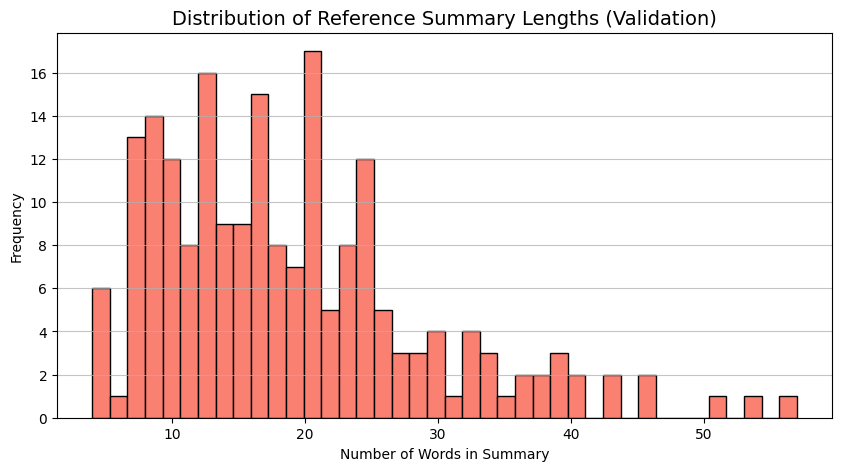

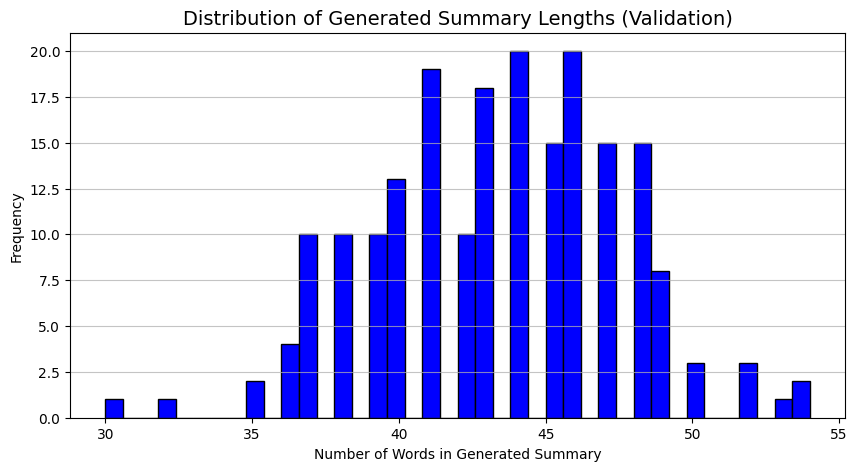

In [28]:
import matplotlib.pyplot as plt

# Histogram of human reference summary lengths (validation)
plt.figure(figsize=(10, 5))
plt.hist(val_stats["summary_len_words"].dropna(), bins=40, color="salmon", edgecolor="black")
plt.title("Distribution of Reference Summary Lengths (Validation)", fontsize=14)
plt.xlabel("Number of Words in Summary")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# (Optional) Histogram of model-generated summary lengths (validation)
plt.figure(figsize=(10, 5))
plt.hist(val_stats["generated_summary_len_words"].dropna(), bins=40, color="blue", edgecolor="black")
plt.title("Distribution of Generated Summary Lengths (Validation)", fontsize=14)
plt.xlabel("Number of Words in Generated Summary")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

The histogram plots show summaries are consistently longer than human references and not length-adaptive. Tightening and adapting length should reduce redundancy, better match SAMSum’s style, and likely improve perceived quality (and possibly ROUGE-Lsum) without retraining.

## Additional aggregated measures

In [29]:
import numpy as np

# Safe copies that avoid divide-by-zero
dlg_words = val_stats["dialogue_len_words"].replace(0, np.nan)
ref_words = val_stats["summary_len_words"].replace(0, np.nan)
gen_words = val_stats["generated_summary_len_words"].replace(0, np.nan)
turns     = val_stats["turns"].replace(0, np.nan)

avg_words_per_dialogue = dlg_words.mean()
avg_words_per_turn     = (dlg_words / turns).mean()
comp_ratio_ref_vs_dlg  = (ref_words / dlg_words).mean()                 # reference / dialogue
comp_ratio_gen_vs_dlg  = (gen_words / dlg_words).mean()                 # generated / dialogue
comp_ratio_gen_vs_ref  = (gen_words / ref_words).mean()                 # generated / reference

print("=== Aggregated stats (validation) ===")
print(f"Avg words per dialogue: {avg_words_per_dialogue:.2f}")
print(f"Avg words per speaker turn: {avg_words_per_turn:.2f}")
print(f"Avg compression ratio (reference / dialogue): {comp_ratio_ref_vs_dlg:.3f}")
print(f"Avg compression ratio (generated / dialogue): {comp_ratio_gen_vs_dlg:.3f}")
print(f"Avg compression ratio (generated / reference): {comp_ratio_gen_vs_ref:.3f}")

=== Aggregated stats (validation) ===
Avg words per dialogue: 91.51
Avg words per speaker turn: 8.17
Avg compression ratio (reference / dialogue): 0.280
Avg compression ratio (generated / dialogue): 0.809
Avg compression ratio (generated / reference): 3.063


**Summary**

Validation spotlight (n=200 for quick diagnostics). This validation slice shows chats average 91.5 words with 8.2 words/turn. Human summaries compress aggressively—~28% of the dialogue length—while the model’s outputs are much longer: ~81% of the dialogue (compression ratio 0.809) and roughly 3.06× the length of human references. In short, the system is producing near “mini-paraphrases” instead of concise summaries, which increases verbosity and the chance of factual drift without improving content coverage.

The large generated/reference gap (3.06×) explains why outputs feel wordy and why ROUGE gains remain small: extra words rarely add aligned n-grams.

A high generated/dialogue ratio (0.809) indicates weak length control; summaries should typically land around 25–35% of the source for SAMSum-style briefs.

On average, the model's summary is 81% of the dialogue length but summaries longr thatn the dialoue can happen for very short chats because the generator produces 40-48 word summaries. Any dialogue shorter than 40 words will often get a “summary”  longer than the source. In practice, that means the model is not compressing; it's expanding/rephrasing and sometimes repeating, which increases reading time and raises the risk of small hallucinations.

# How well does the model handle different dialogue scenarios?

Short chats (≤40 words): Weak. The model tends to emit 40–48 words regardless of input, so it often over-explains and can be longer than the source. Mitigation: lower max_new_tokens (32–40) or use a length-adaptive cap (≈25% of dialogue words).

Medium chats (≈40–120 words, 6–14 turns): Strongest. Outputs are generally coherent and on-topic; small ROUGE gains from Phase B came largely from this band.

Long chats (≥120 words or ≥15 turns): Mixed. Risk of role attribution and detail drift rises; the 64-token cap can miss late context. Mitigation: modestly raise cap (to 80–96) or summarize in two passes (chunk → merge).

Humor/sarcasm/jokes (e.g., “lol”, “haha”, “xD”, emojis): Weak. The model literalizes jokes as facts; ROUGE is unreliable here because human references are noisy. Mitigation: optional tone tag (detect humor → summarize as “banter/highlights”).

Heavy punctuation/emoji/ellipses: Generally robust; punctuation is normalized by the tokenizer. Issues are more about verbosity than punctuation errors.

Numbers/percentages present: Watch for numeric drift (“20% decrease” → “20% faster”). Mitigation: light repetition_penalty, numeric copy constraints or a post-check that numbers in the dialogue appear unchanged in the summary.

Bottom line: Best on medium, factual chats; weakest on very short, very long, humorous, and number-heavy threads. Most fixes are decoding-only (brevity, caps, repetition control) and can be shipped without retraining.

# Recommendations for Future Work (with More Resources / Time)

With more time and compute, the project can move beyond decoding-only optimization to stronger models, cleaner data, smarter decoding, and richer evaluation—all of which would yield more meaningful improvements than the small ROUGE gains observed in Phase B.

**Model-Level Improvements**

Fine-tune on SAMSum with other encoder–decoder architectures, which might perform better on abstractive summarization than BERT2BERT.

Use a cased variant or apply truecasing during preprocessing to improve style and readability of names and proper nouns.

Apply domain-adaptive pretraining (DAPT) to better capture conversational tone and humor.

**Data Enhancements**

Enforce human-like brevity via adaptive **max_dec_steps**, add light numeric/entity constraints, expand data beyond SAMSum (DialogSum/MediaSum) or upgrade backbones (BART/T5), and track semantic/factual metrics alongside ROUGE.

Human references in SAMSum often contain inaccuracies. Building a curated subset with corrected summaries would provide more reliable supervision and evaluation.

Using dialogue-to-summary datasets beyond SAMSum (DialogSum, MediaSum) could increase robustness and reduce hallucinations.

**Advanced Decoding & Post-Processing**

Add lexical constraints to enforce copying of numbers, percentages, or named entities directly from the dialogue to prevent numeric hallucinations.

Lightweight regex or entity-matching rules to validate generated facts against the source dialogue (e.g., ensure “20% decrease” isn’t changed to “20% faster”).

**Evaluation & Metrics**

Complement ROUGE with semantic metrics (BERTScore, BLEURT, QAFactEval) to better capture factual correctness and conversational intent.

Ask annotators (interns) to rate factuality, conciseness, and tone preservation, which ROUGE cannot measure.

**System-Level Extensions**

Allow end-users to set a style preference (concise fact vs. conversational highlight) to adapt decoding dynamically.

Train the model to both summarize and classify dialogue tone (informative vs. humorous), helping the system decide whether to preserve humor or condense facts.

**Actionable in decoding now** Based on other metrics
- Tighten decoding for brevity: lower max_new_tokens (32-40) and consider length_penalty ≈ 0.6
- Make length adaptive to each dialogue: target = int(0.25 * dialogue_len_words) plus max_new_tokens = max(16, min(target, 40))
- Reduce filler: add a light repetition_penalty (≈ 1.05–1.15) and a post-check for duplicate sentences.
- Track faithfulness at human-like compression: report a length-aligned ROUGE slice (subset where generated length ≈ 0.25–0.35× dialogue).

